In [1]:
import numpy as np 
import pandas as pd
import scipy.linalg as la
import matplotlib.pyplot as plt
from itertools import product 

In [2]:
training_set = pd.read_csv('TrainingRidge.csv')
validation_set = pd.read_csv('ValidationRidge.csv')

# (a)

In [3]:
def sphering(X):
    mean = np.mean(X, axis=1, keepdims=True)

    centered = X - mean
   
    cov_X = np.cov(X, bias=True)

    e_vals, e_vecs = la.eig(cov_X)
    e_vals_diag = np.diag(1./e_vals.real**0.5)

    decorrelated = e_vecs.T@centered

    whitened = e_vals_diag@decorrelated

    return whitened, mean, e_vecs, e_vals_diag 

In [4]:
def sphering_val(X, mean, e_vecs, e_vals_diag):
    centered = X - mean
   
    decorrelated = e_vecs.T@centered

    whitened = e_vals_diag@decorrelated

    return whitened

In [5]:
whitened_training, mean, e_vecs, e_vals_diag = sphering(training_set[['x1', 'x2']].to_numpy().T)

In [6]:
whitened_validation = sphering_val(validation_set[['x1', 'x2']].to_numpy().T, mean, e_vecs, e_vals_diag)

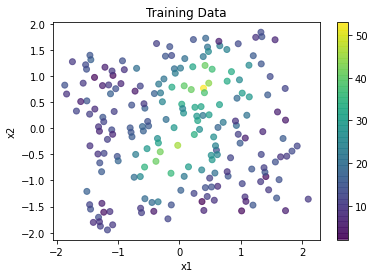

In [7]:
plt.title('Training Data')
plt.scatter(whitened_training[0,:], whitened_training[1,:], alpha=0.7, c =training_set['obs'].to_numpy())
plt.xlabel('x1')
plt.ylabel('x2')

plt.colorbar()
plt.show()

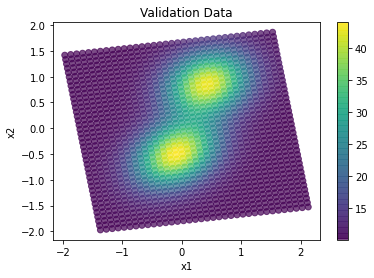

In [8]:
plt.title('Validation Data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(whitened_validation[0,:],whitened_validation[1,:], alpha=0.7, c =validation_set['dens'].to_numpy())
plt.colorbar()
plt.show()

# (b)

In [9]:
def monomial_transform(X, degree ):
    num_features = X.shape[0]
    num_data = X.shape[1]
    pol_list = []
    
    for i in range(num_features):
        
        poly = np.zeros((degree+1, X.shape[1])) #power to 0
        
        poly[0,:] = np.ones((1,X.shape[1]))
        for d in range(1,degree+1):
            poly[d,:] = poly[d-1,:] * X[i,:]     
        pol_list.append(poly)
    
    #creating list of indices
    comb_filtered = np.zeros((1,num_features))
    for d in range(degree+1):

        comb = np.array(list(product(range(d+1), repeat=num_features))) 
        indices = np.sum(comb, axis=1) == d

        comb_filtered = np.concatenate((comb_filtered,comb[indices]), axis=0)
    comb_filtered = comb_filtered[1:,:]
    
    ret_dict = {}

    for i in range(comb_filtered.shape[0]):
        power = ''      
        temp = np.ones(num_data)
        for j in range(num_features):
            cur_pow = int(comb_filtered[i,j])
            power += 'x{}^{} '.format(j+1,cur_pow)

            temp *= pol_list[j][cur_pow]
        ret_dict[power] = temp

    return ret_dict

In [10]:
transformed_validation_set = pd.DataFrame.from_dict(monomial_transform(whitened_validation,9)) 
mono_features_list = transformed_validation_set.columns.to_list()

transformed_validation_set['y'] = validation_set['dens']
print(transformed_validation_set.head())

   x1^0 x2^0   x1^0 x2^1   x1^1 x2^0   x1^0 x2^2   x1^1 x2^1   x1^2 x2^0   \
0         1.0    1.862130    1.527297    3.467529    2.844026    2.332636   
1         1.0    1.849412    1.427315    3.420326    2.639694    2.037228   
2         1.0    1.836695    1.327333    3.373447    2.437906    1.761813   
3         1.0    1.823977    1.227351    3.326892    2.238660    1.506391   
4         1.0    1.811259    1.127369    3.280660    2.041958    1.270961   

   x1^0 x2^3   x1^1 x2^2   x1^2 x2^1   x1^3 x2^0   ...  x1^1 x2^8   \
0    6.456990    5.295947    4.343672    3.562629  ...  220.802451   
1    6.325594    4.881884    3.767676    2.907767  ...  195.339505   
2    6.195993    4.477689    3.235913    2.338513  ...  171.899935   
3    6.068174    4.083265    2.747622    1.848871  ...  150.356977   
4    5.942125    3.698515    2.302041    1.432843  ...  130.590315   

   x1^2 x2^7   x1^3 x2^6   x1^4 x2^5   x1^5 x2^4   x1^6 x2^3   x1^7 x2^2   \
0  181.099543  148.535691  121.827207  

In [11]:
transformed_training_set = pd.DataFrame.from_dict(monomial_transform(whitened_training,9))
transformed_training_set['y'] = training_set['obs']
print(transformed_training_set.head())

   x1^0 x2^0   x1^0 x2^1   x1^1 x2^0   x1^0 x2^2   x1^1 x2^1   x1^2 x2^0   \
0         1.0   -1.357727    2.097544    1.843424   -2.847893    4.399690   
1         1.0   -0.540279   -1.012024    0.291902    0.546775    1.024192   
2         1.0   -1.404463    0.367838    1.972517   -0.516615    0.135305   
3         1.0    1.175683    0.217589    1.382230    0.255815    0.047345   
4         1.0    1.272978   -1.742094    1.620473   -2.217647    3.034892   

   x1^0 x2^3   x1^1 x2^2   x1^2 x2^1   x1^3 x2^0   ...  x1^1 x2^8   \
0   -2.502867    3.866662   -5.973579    9.228542  ...   24.222093   
1   -0.157708   -0.295411   -0.553349   -1.036506  ...   -0.007347   
2   -2.770327    0.725566   -0.190030    0.049770  ...    5.568510   
3    1.625065    0.300758    0.055663    0.010302  ...    0.794252   
4    2.062826   -2.823016    3.863350   -5.287068  ...  -12.012641   

   x1^2 x2^7   x1^3 x2^6   x1^4 x2^5   x1^5 x2^4   x1^6 x2^3   x1^7 x2^2   \
0  -37.420545   57.810745  -89.311424  

## (i)

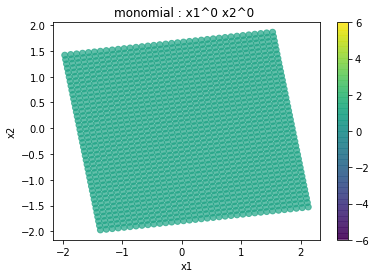

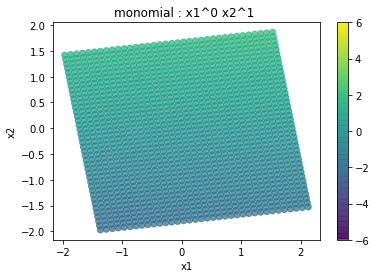

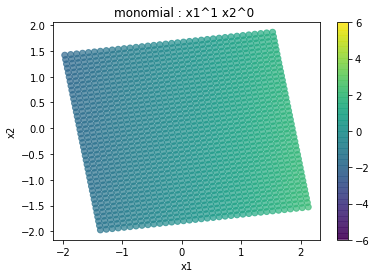

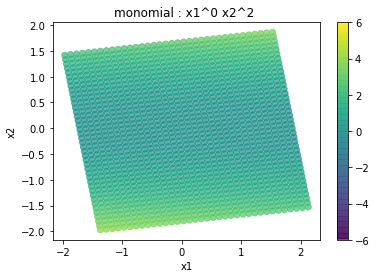

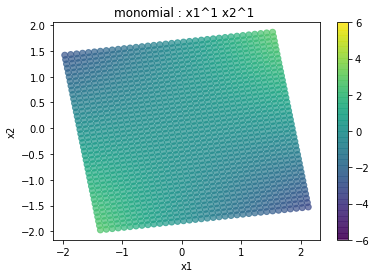

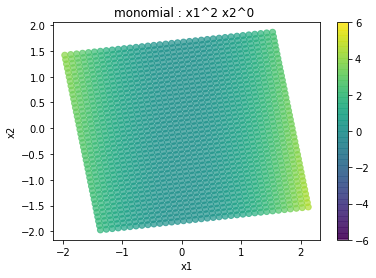

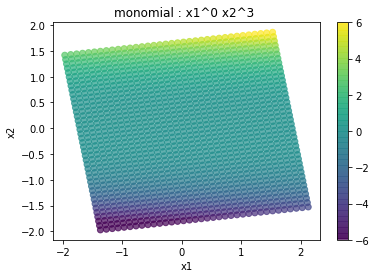

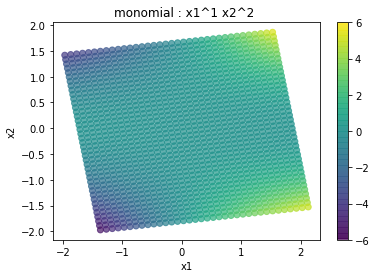

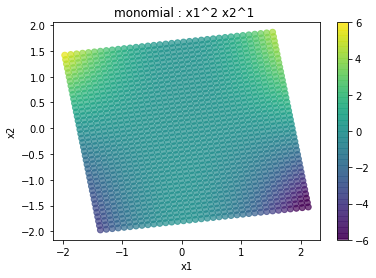

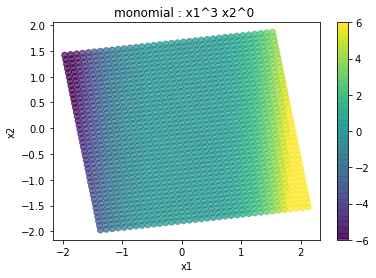

In [12]:
for mono in mono_features_list[:10]:
    plt.title('monomial : '+mono)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.scatter(
        whitened_validation[0,:],
        whitened_validation[1,:], 
        alpha=0.7, 
        c = transformed_validation_set[mono].to_numpy(),
        vmin=-6,
        vmax=6)
    plt.colorbar()
    plt.show()


## (ii)

In [13]:
phi_train = transformed_training_set[mono_features_list].to_numpy().T
y_train = transformed_training_set['y'].to_numpy().T.reshape(1,-1)

In [14]:
w_star = np.linalg.inv(phi_train @ phi_train.T) @ phi_train @ y_train.T

In [15]:
y_pred = w_star.T @ phi_train

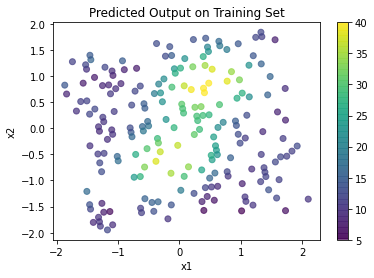

In [16]:
plt.title('Predicted Output on Training Set')
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(
    whitened_training[0,:],
    whitened_training[1,:], 
    alpha=0.7, 
    c = y_pred,
    vmin=5,
    vmax=40)
plt.colorbar()
plt.show()


In [17]:
phi_validation = transformed_validation_set[mono_features_list].to_numpy().T
y_validation = transformed_validation_set['y'].to_numpy().T.reshape(1,-1)
y_pred_validation = w_star.T @ phi_validation

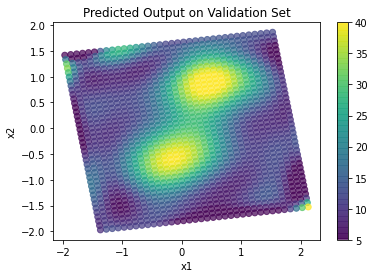

In [18]:
plt.title('Predicted Output on Validation Set')
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(
    whitened_validation[0,:],
    whitened_validation[1,:], 
    alpha=0.7, 
    c = y_pred_validation,
    vmin=5,
    vmax=40)
plt.colorbar()
plt.show()


# (c)

In [24]:
def train_l2(x_train, y_truth, lmbda):
    temp = x_train @ x_train.T
    temp = temp + lmbda*np.identity(temp.shape[0])
    w_star = np.linalg.inv(temp) @ x_train @ y_truth.T

    return w_star

In [25]:
def n_fold(X, y, lambd, n_fold=10):
    n_valid = int(X.shape[1]/n_fold)
    mse = 0
    for i in range(n_fold):
   
        val_idx_l = i*n_valid
        val_idx_h = (i+1)*n_valid 

        x_val = X[:,val_idx_l:val_idx_h]        
        y_val = y[:,val_idx_l:val_idx_h]

        x_train = X[:,0:val_idx_l]
        x_train = np.concatenate((x_train, X[:,val_idx_h:]), axis=1)

        y_train = y[:,0:val_idx_l]
        y_train = np.concatenate((y_train, y[:,val_idx_h:]), axis=1)
        
        w_star = train_l2(x_train, y_train, lambd)

        y_pred_val = w_star.T @ x_val

        mse += 0.5*((y_pred_val - y_val)**2).mean(axis=1)
    return mse/float(n_fold)

In [26]:
t_lambdas = np.power(10,np.arange(-4,4,0.1)).tolist() 
mses = []
for lambd in t_lambdas:
    mse = n_fold(phi_train, y_train, lambd =lambd)
    mses.append(mse)

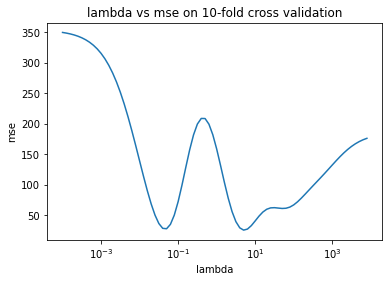

In [27]:
plt.plot(t_lambdas, mses)
plt.title('lambda vs mse on 10-fold cross validation')
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('mse')
plt.show()

In [28]:
mses = np.array(mses)
idx_min = np.argmin(mses)

t_lambda_min = t_lambdas[idx_min]
print('lambda with lowest mse value : {}'.format(t_lambda_min))
print('with mse : {}'.format(float(mses[idx_min])))

lambda with lowest mse value : 5.011872336272776
with mse : 25.30084586446828


In [47]:
w_star_t = train_l2(phi_train, y_train, t_lambda_min)

y_pred_val = w_star_t.T @ phi_validation

mse = 0.5*((y_pred_val - y_validation)**2).mean(axis=1)

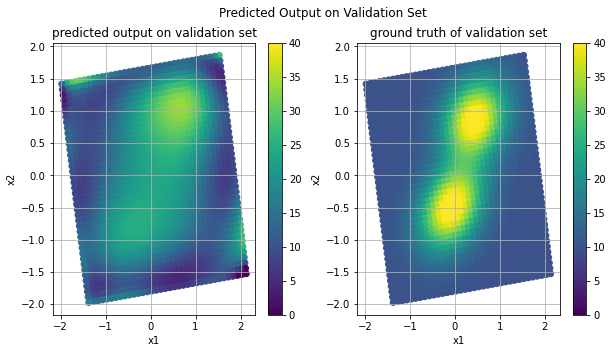

mse with lambda 5.011872336272776 on validation set: 12.337925643934428


In [48]:
fig, axs = plt.subplots(1, 2,figsize=(10,5))

fig.suptitle('Predicted Output on Validation Set')

im = axs[0].scatter(
    whitened_validation[0,:],
    whitened_validation[1,:], 
    c=y_pred_val,
    vmin=0,
    vmax=40)
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')
axs[0].grid()
axs[0].set_title('predicted output on validation set')
fig.colorbar(im, ax=axs[0])

im = axs[1].scatter(
    whitened_validation[0,:],
    whitened_validation[1,:], 
    c=y_validation,
    vmin=0,
    vmax=40)
axs[1].set_xlabel('x1')
axs[1].set_ylabel('x2')
axs[1].grid()
axs[1].set_title('ground truth of validation set')
fig.colorbar(im, ax=axs[1])

plt.show()

print('mse with lambda {} on validation set: {}'.format(t_lambda_min, float(mse)))

# (d)

In [49]:
mses = []
for lambd in t_lambdas:
    mse = n_fold(phi_validation, y_validation, lambd =lambd)
    mses.append(mse)

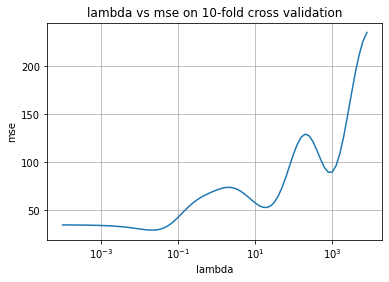

In [50]:
plt.plot(t_lambdas, mses)
plt.title('lambda vs mse on 10-fold cross validation')
plt.xscale('log')
plt.xlabel('lambda')
plt.ylabel('mse')
plt.grid()
plt.show()

In [51]:
mses = np.array(mses)
idx_min = np.argmin(mses)

g_lambda_min = t_lambdas[idx_min]
print('lambda with lowest mse value : {}'.format(g_lambda_min))
print('with mse : {}'.format(float(mses[idx_min])))

lambda with lowest mse value : 0.01995262314968889
with mse : 29.449939745382288


In [52]:
w_star_g = train_l2(phi_validation, y_validation, g_lambda_min)

y_pred_val = w_star_g.T @ phi_validation

mse = 0.5*((y_pred_val - y_validation)**2).mean(axis=1)

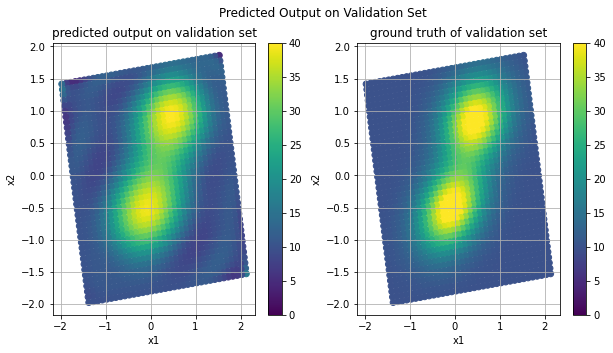

mse with lambda 5.011872336272776 on validation set = 0.8508877780463032


In [53]:
fig, axs = plt.subplots(1, 2,figsize=(10,5))

fig.suptitle('Predicted Output on Validation Set')

im = axs[0].scatter(
    whitened_validation[0,:],
    whitened_validation[1,:], 
    c=y_pred_val,
    vmin=0,
    vmax=40)
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')
axs[0].grid()
axs[0].set_title('predicted output on validation set')
fig.colorbar(im, ax=axs[0])

im = axs[1].scatter(
    whitened_validation[0,:],
    whitened_validation[1,:], 
    c=y_validation,
    vmin=0,
    vmax=40)
axs[1].set_xlabel('x1')
axs[1].set_ylabel('x2')
axs[1].grid()
axs[1].set_title('ground truth of validation set')
fig.colorbar(im, ax=axs[1])

plt.show()

print('mse with lambda {} on validation set = {}'.format(t_lambda_min, float(mse)))

# (e)

In [56]:
y_pred_t_on_t = w_star_t.T @ phi_train
y_pred_v_on_t = w_star_g.T @ phi_train

mse_t_on_t = 0.5*((y_pred_t_on_t - y_train)**2).mean(axis=1)
mse_v_on_t = 0.5*((y_pred_v_on_t - y_train)**2).mean(axis=1)

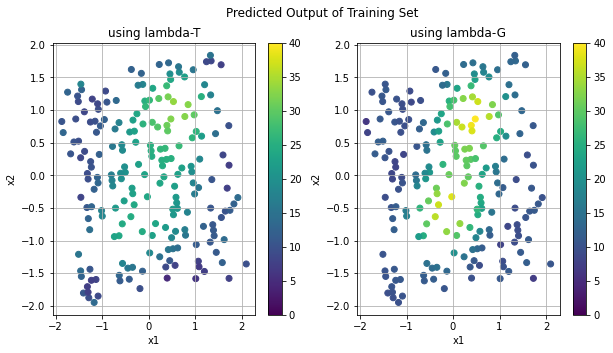

mse of the pediction output of the two function is : [6.97845345]


In [59]:
fig, axs = plt.subplots(1, 2,figsize=(10,5))

fig.suptitle('Predicted Output of Training Set')

im = axs[0].scatter(
    whitened_training[0,:],
    whitened_training[1,:], 
    c=y_pred_t_on_t,
    vmin=0,
    vmax=40)
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')
axs[0].grid()
axs[0].set_title('using lambda-T')
fig.colorbar(im, ax=axs[0])

im = axs[1].scatter(
    whitened_training[0,:],
    whitened_training[1,:], 
    c=y_pred_v_on_t,
    vmin=0,
    vmax=40)
axs[1].set_xlabel('x1')
axs[1].set_ylabel('x2')
axs[1].grid()
axs[1].set_title('using lambda-G')
fig.colorbar(im, ax=axs[1])

plt.show()

diff_mse = 0.5*((y_pred_v_on_t - y_pred_t_on_t)**2).mean(axis=1)

print('mse of the pediction output of the two function is : {}'.format(diff_mse))

In [61]:
y_pred_t_on_v = w_star_t.T @ phi_validation
y_pred_v_on_v = w_star_g.T @ phi_validation

mse_t_on_v = 0.5*((y_pred_t_on_v - y_validation)**2).mean(axis=1)
mse_v_on_v = 0.5*((y_pred_v_on_v - y_validation)**2).mean(axis=1)

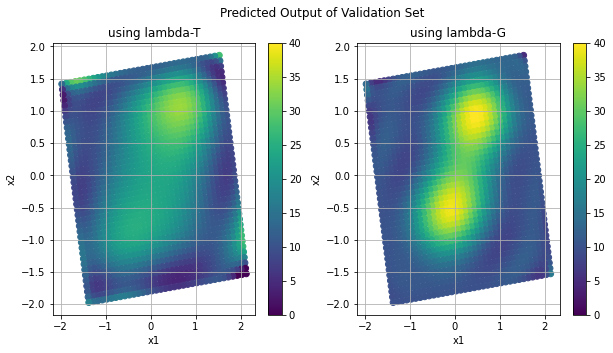

mse of the pediction output of the two function is : [11.36248126]


In [63]:
fig, axs = plt.subplots(1, 2,figsize=(10,5))

fig.suptitle('Predicted Output of Validation Set')

im = axs[0].scatter(
    whitened_validation[0,:],
    whitened_validation[1,:], 
    c=y_pred_t_on_v,
    vmin=0,
    vmax=40)
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')
axs[0].grid()
axs[0].set_title('using lambda-T')
fig.colorbar(im, ax=axs[0])

im = axs[1].scatter(
    whitened_validation[0,:],
    whitened_validation[1,:], 
    c=y_pred_v_on_v,
    vmin=0,
    vmax=40)
axs[1].set_xlabel('x1')
axs[1].set_ylabel('x2')
axs[1].grid()
axs[1].set_title('using lambda-G')
fig.colorbar(im, ax=axs[1])

plt.show()

diff_mse = 0.5*((y_pred_v_on_v - y_pred_t_on_v)**2).mean(axis=1)

print('mse of the pediction output of the two function is : {}'.format(diff_mse))